In [1]:
import torch
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from transformers import AutoModel
from datasets import load_dataset, Image
from transformers import ViTFeatureExtractor

### Pre-calculate embeddings for train dataset.

Load trained model.

In [2]:
WEIGHTS = "../ml-server/mlmodels/vit-potatoes-plant-health-status/"
feature_extractor = ViTFeatureExtractor.from_pretrained(WEIGHTS)
model = AutoModel.from_pretrained(WEIGHTS)

/srv/conda/envs/saturn/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at ../ml-server/mlmodels/vit-potatoes-plant-health-status/ were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at ../ml-server/mlmodels/vit-

Load train dataset, we will use it to calculate candidates embeddings.

In [3]:
dataset = load_dataset("imagefolder", data_files={"train": "../dataset/PLD_3_Classes_256/Training/**"})
#Add path column 
def path_column(example):
    example["path"] = example["image"].filename.split('/Training/')[-1]
    return example
dataset = dataset.map(path_column)

train_ds = dataset['train']

Resolving data files:   0%|          | 0/3251 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/imagefolder/default-7c321e6a57781d94/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3251 [00:00<?, ? examples/s]

In [4]:
normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
resize = tuple(feature_extractor.size.values())
_val_transforms = transforms.Compose([transforms.Resize(resize),                          
                                       transforms.ToTensor(), normalize
                                       ])

Calculate embeddings for the whole train dataset./

In [5]:
def extract_embeddings(model):
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [_val_transforms(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_emb = train_ds.map(extract_fn, batched=True, batch_size=32)

Map:   0%|          | 0/3251 [00:00<?, ? examples/s]

In [7]:
candidate_ids = []
for id in range(len(candidate_emb)):
    label = candidate_emb[id]["label"]
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

all_candidate_embeddings = np.array(candidate_emb["embeddings"])

Save embeddings, paths to images and ids.

In [9]:
np.savez_compressed('../ml-server/mlmodels/train_embeddings.npz', emb = all_candidate_embeddings,ids = np.array(candidate_ids),\
                   paths = np.array(candidate_emb['path']))

In [8]:
loaded = np.load('../ml-server/mlmodels/train_embeddings.npz')
all_candidate_embeddings = loaded['emb']
candidate_ids = loaded['ids']
candidate_paths = loaded['paths']
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

Define functions to calculate cosine similarity and to find most similar embeddings to the query.

In [9]:
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    image_transformed = _val_transforms(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(zip(candidate_ids,candidate_paths), sim_scores))
 
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x[0].split("_")[0]), id_entries))
    paths = list(map(lambda x: x[1], id_entries))
    labels = list(map(lambda x: int(x[0].split("_")[-1]), id_entries))
    return ids, labels, paths

### Test.

In [10]:
from PIL import Image

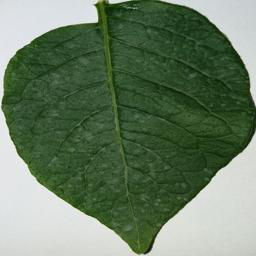

In [11]:
image = Image.open('../ml-server/tests/images/healthy.jpeg')
image

In [12]:
sim_ids, sim_labels, sim_paths = fetch_similar(image)
print(f"Query label: Healthy")
print(f"Top 5 candidate labels: {sim_labels}")
print(f"Top 5 candidate labels: {sim_paths}")

Query label: Healthy
Top 5 candidate labels: [1, 1, 1, 1, 1]
Top 5 candidate labels: ['Healthy/Healthy_5.jpg', 'Healthy/Healthy_6.jpg', 'Healthy/Healthy_8.jpg', 'Healthy/Healthy_3.jpg', 'Healthy/Healthy_14.jpg']


In [13]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(model.config.id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(model.config.id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

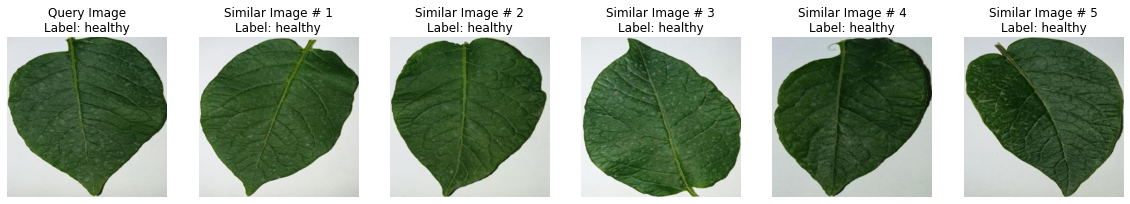

In [14]:
images = [image]
labels = [1]

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_emb[id]["image"])
    labels.append(candidate_emb[id]["label"])
plot_images(images, labels)